# 300 GAN Tutorial Notebook

This Notebook should give a quick introduction to the inner workings of GANs by showing how to write a GAN that produces handwritten digits from the MNIST Database. The code is dependant on keras, matplotlib and numpy while using Tensorflow 2.X.


## Sources:
MNIST Database:
 - http://yann.lecun.com/exdb/mnist/

Papers:
 - https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf

Tutorials:
 - https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb#scrollTo=gL5byGhNzOzd
 - https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
 

## Training a GAN

### Step 1

Training takes place in two steps shown below. In the first step, the discriminator is trained to classify between real and generated digits. A vector from the latent space (*LATENT_DIM*) full of random numbers is inputted into the generator. The generator takes these numbers and creates a small image with dimensions 7 x 7. Then, this small image is upscaled with *Conv2DTranspose* to 14 x 14 and then to 28 x 28 in the subsequent two layers. We finally apply sigmoid to the values and have successfully generated an image from a vector from the latent space.

128 *image_samples* from the MNIST dataset and 128 *generated_images* form the dataset *images_all* and values *y_all* for the first step. This is passed to the discriminator, while real images are labeled with 1 and generated "fake" images are labeled with 0. Backpropagation is applied to optimize the discriminator.


### Step 2

The second step trains the generator. Generator and discriminator are combined to form one big network called *gan_model*. d_model.trainable = False makes sure the discriminator is not trained. Making a big model helps make the code for training simpler.

Again, a full batch (*n_batch = 256*) of vectors from the latent space is generated. They are passed into the *gan_model*, which generates fake images inside it and then uses the discriminator to try and tell real and generated images apart.

y_generator_flipped = np.ones((n_batch, 1)), because the generator should be taught to trick the discriminator into thinking that fake generated images (0) are actually real (1). This metric is used to optimize the generator.


<img src="GAN with MNIST-1.png">
<img src="GAN with MNIST-2.png">


(60000, 28, 28, 1)
(60000,)


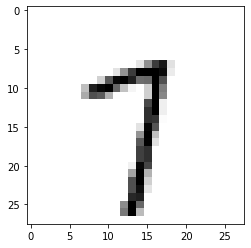

In [1]:
import tensorflow as tf
import numpy as np

import csv
import random

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
# from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt



mnist = tf.keras.datasets.mnist

# Expand Dimensions to 3D to add one for the color channel of black and white: expand_dims(train_images, axis=-1)
# Normalize the image by dividing by 255 --> faster convergence
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = np.expand_dims(train_images, axis=-1) / 255.0, np.expand_dims(train_images, axis=-1) / 255.0


# Examples
# Shape is (60000, 28, 28, 1) for 60 000 images with dimensions 28 x 28 and 1 color channel (black and white)
print(train_images.shape)
print(train_labels.shape)

plt.imshow(train_images[0, :, :, 0], cmap='gray_r')
plt.imshow(train_images[42, :, :, 0], cmap='gray_r')

In [2]:
# Two helper functions

# Sample minibatch of m MNIST samples from seed:
def get_MNIST_samples(n_samples):
    # Pick new image samples from dataset
    # Pick random images to help with gradient descent
    image_samples = np.zeros((n_samples, 28, 28, 1))

    for i in range(0, n_samples):
        index = random.randint(0, 59999)
        image_samples[i] = train_images[index]

    # Generate actual class labels (1)
    y_MNIST = np.ones((n_samples, 1))

    return image_samples, y_MNIST


# Sample minibatch of m noise samples from seed:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    latent_points = np.random.randn(latent_dim * n_samples)

    # reshape into a batch of inputs for the network
    latent_points = latent_points.reshape(n_samples, latent_dim)

    return latent_points


# Examples
latent_points_example = generate_latent_points(100, 1)
print(latent_points_example)

# Examples
MNIST_example = get_MNIST_samples(1)
# plt.imshow(MNIST_example[0, :, :, 0], cmap='gray_r')

[[-0.99135029  0.20260851 -1.03799632 -0.64160533 -1.63986893  1.18585547
  -0.14389768  0.77598984  0.1729118  -0.52700883  0.41263793  1.30791926
  -0.45463668  1.96842719  0.09341416 -0.43718706 -0.61900659 -1.16332592
  -1.72466484 -0.09300866 -0.26206198 -0.23657669 -0.33997426 -1.35234981
  -0.42896121  0.25227193  0.36468466 -0.64470028  0.02674817 -0.01138662
  -1.45650008 -0.03154641 -0.62816304 -0.69153291 -0.7708117  -0.18408072
   0.04983312 -1.7305672   1.87321838 -0.01841083 -0.74389071  2.46725246
   0.06075403 -0.10999764 -0.17987015 -1.3390663  -1.24578983  0.70657427
   0.03582405  0.97999196  0.74086061 -0.36567633  0.16163041 -0.97297847
  -0.78648493  0.16278246  0.7800854  -1.28244364  1.33590928  0.3094771
  -0.56542156 -0.724249    0.38137412 -0.55623255 -1.49709667  0.24002343
   0.84265301 -0.70792023  1.79560782  1.16542192 -0.94116912  0.43341626
   0.69917027  0.69100149 -1.09001207  0.6755487  -0.44333785  0.11354847
   0.11997992 -0.66580042 -0.85247326  

Discriminator Output:  [[0.47714648]]


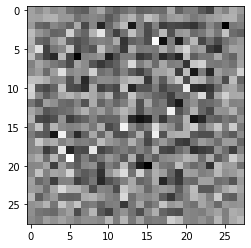

In [3]:
# Define all 3 models with the help of Keras

# Define the standalone generator model
def build_generator(LATENT_DIM=100):
    model = Sequential()

    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=LATENT_DIM))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))

    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 28x28
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))

    return model


# Define the standalone discriminator model
def build_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


# Define the combined generator and discriminator model, for updating the generator
def build_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False

    # connect them
    model = Sequential()

    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)

    # compile model
    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return model


# Example Generator
generator_example = build_generator()
latent_points_example = generate_latent_points(100, 1)

generated_images_example = generator_example.predict(latent_points_example)
plt.imshow(generated_images_example[0, :, :, 0], cmap='gray_r')

# Example Discriminator
discriminator_example = build_discriminator()

prediction_example = discriminator_example.predict(generated_images_example)
print('Discriminator Output: ', prediction_example)

In [4]:
# Train the model
def train(generator, discriminator, gan_model, LATENT_DIM, n_epochs=100, n_batch=256):
    
    batches_per_epoch = int(60000 / n_batch)
    n_half_batch = int(n_batch / 2)

    for epoch in range(0, n_epochs):
        for batch in range(0, batches_per_epoch):
            
            # Get real image samples from MNIST dataset
            image_samples, y = get_MNIST_samples(n_half_batch)
            # Generate points from the latent space (Size: n_half_batch)
            latent_points = generate_latent_points(LATENT_DIM, n_half_batch)
            # Generate 'fake' class label (0)
            y_generator = np.zeros((n_half_batch, 1))

            # Generate fake images by inputting the latent_points into the generator
            generated_images = generator.predict(latent_points)

            # Step 1 ************
            # np.vstack stacks arrays in sequence vertically (row wise) -> combine real and generated datasets
            images_all, y_all = np.vstack((image_samples, generated_images)), np.vstack((y, y_generator))
            # Update the discriminator loss
            discriminator_loss, _ = discriminator.train_on_batch(images_all, y_all)

            # Step 2 ************
            # Generate points from the latent space (Size: this time n_batch)
            latent_points = generate_latent_points(LATENT_DIM, n_batch)
            # Generate 'fake' class label, but flip them to trip disciminator into thinking it is real (not 0, but 1)
            y_generator_flipped = np.ones((n_batch, 1))
            generator_loss = gan_model.train_on_batch(latent_points, y_generator_flipped)

            print('Epoch: ', epoch, '   Batch Number: ', batch, ' / ', batches_per_epoch, '   Generator Loss: ', generator_loss, '   Discriminator Loss: ', discriminator_loss)

            if batch % 25 == 0:
                # Matplotlib to capture generated the images ###
                fig = plt.figure()
                for a in range(32):
                    ax = fig.add_subplot(6, 6, a + 1)
                    plt.imshow(generated_images[a, :, :, 0], cmap='gray_r')

                # Plots are saved with 4 digit numbers in the name to avoid flickering in the video
                plt.savefig('plot  epoch ' + '%02d' % epoch + '  batch ' + '%05d' % batch + '.png', dpi=600)
                plt.close()
                # End Matplotlib                             ###

                # Save the generator and discriminator
                generator.save('generator.h5')
                discriminator.save('discriminator.h5')

In [5]:
# Build the GAN ************

# Size of the latent space
LATENT_DIM = 100


# Define the discriminator
discriminator = build_discriminator()
# Define the generator
generator = build_generator(LATENT_DIM)
# Define the gan
gan_model = build_gan(generator, discriminator)


# Train model
train(generator, discriminator, gan_model, LATENT_DIM)

Epoch:  0    Batch Number:  0  /  234    Generator Loss:  0.720980703830719    Discriminator Loss:  0.6956827640533447
Epoch:  0    Batch Number:  1  /  234    Generator Loss:  0.7416566610336304    Discriminator Loss:  0.6865015029907227
Epoch:  0    Batch Number:  2  /  234    Generator Loss:  0.7594889402389526    Discriminator Loss:  0.676751971244812
Epoch:  0    Batch Number:  3  /  234    Generator Loss:  0.7785246968269348    Discriminator Loss:  0.6650537252426147
Epoch:  0    Batch Number:  4  /  234    Generator Loss:  0.7952412366867065    Discriminator Loss:  0.6633268594741821
Epoch:  0    Batch Number:  5  /  234    Generator Loss:  0.804670512676239    Discriminator Loss:  0.6584080457687378
Epoch:  0    Batch Number:  6  /  234    Generator Loss:  0.8220213055610657    Discriminator Loss:  0.6521784067153931


KeyboardInterrupt: 